## Section 03: Turn and River Equity Calculation
**Abstract**: In this notebook, we calculate the turn and river equity for each player's hand based on various engineered features derived from the hole cards and community cards. This involves grouping hands by these features and estimating the equity for each group, similar to the approach used for pre-flop and flop equity calculations. Differences in hand features and the results of this experiment rely on the fact that only one more card is to come on the turn, and none on the river, therefore the player's hand is less likely to change in strength compared to the flop.

In [1]:
# Imports
import pandas as pd

**Turn Equity Features**: We estimate turn equity by grouping hands based on features that can be engineered from the hole cards and community cards (flop + turn). These features are the same, however the model should be able to pick up on how certain features do not effect hand strength as much on the turn and river compared to the flop. These features include:
- Hand Classification: Pair, High Card, etc.
- Pocket Pair: Boolean indicating if the hole cards are a pocket pair.
- Suited: Boolean indicating if the hole cards are suited.
- Flush Potential: Complete, Open, or None.
- Straight Potential: Complete, Open, Gut-shot, or None.
- Overcards: Number of hole cards that are higher than the highest card on the board.
- Board Texture: Number of unique suits on the board.
- Board Connectivity: Number of cards required to complete a straight on the board.

In [2]:
# load long-form dataframe
hands_long = pd.read_pickle('../data/hands_long.pkl')

turn_hands = hands_long[[
    'hole_', 'flop', 'turn', 'turn_eval_', 'showdown_order_'
]].copy()

from src.helpers import hand_classification, is_pocket_pair, is_suited, flush_potential, straight_potential, overcards, suit_texture, rank_texture, board_connectivity

# add engineered features for flop equity calculation
turn_hands['hand_class'] = turn_hands['turn_eval_'].apply(hand_classification)
turn_hands['pocket_pair'] = turn_hands['hole_'].apply(is_pocket_pair)
turn_hands['suited'] = turn_hands['hole_'].apply(is_suited)
turn_hands['flush_potential'] = turn_hands[['hole_', 'flop', 'turn']].apply(
    lambda row: flush_potential(row['hole_'], row['flop'] + [row['turn']]),
    axis=1
)
turn_hands['straight_potential'] = turn_hands[['hole_','flop','turn']].apply(
    lambda row: straight_potential(row['hole_'], row['flop'] + [row['turn']]),
    axis=1
)
turn_hands['overcards'] = turn_hands[['hole_', 'flop', 'turn']].apply(
    lambda row: overcards(row['hole_'], row['flop'] + [row['turn']]),
    axis=1
)
turn_hands['suit_texture'] = turn_hands[['flop','turn']].apply(
    lambda row: suit_texture(row['flop'] + [row['turn']]),
    axis=1
)
turn_hands['rank_texture'] = turn_hands[['flop','turn']].apply(
    lambda row: rank_texture(row['flop'] + [row['turn']]),
    axis=1
)
turn_hands['board_connectivity'] = turn_hands[['flop', 'turn']].apply(
    lambda row: board_connectivity(row['flop'] + [row['turn']]),
    axis=1
)
# drop unnecessary columns
turn_hands = turn_hands.drop(columns=['hole_', 'flop', 'turn', 'turn_eval_'])

from src.helpers import total_hands, wins

# multiply by number of players to account for different player counts
turn_hands = pd.concat([turn_hands.assign(players=players) for players in range(2,10)], ignore_index=False)

turn_hands['total_hands'] = turn_hands['players'].apply(total_hands)

turn_hands['wins'] = turn_hands[['showdown_order_','players']].apply(
    lambda row: wins(row['showdown_order_'], row['players']),
    axis=1
)

# aggregate to get total wins and total hands for each condition
turn_equity = turn_hands.groupby(
    ['players', 'hand_class', 'pocket_pair', 'suited', 'flush_potential',
     'straight_potential', 'overcards', 'suit_texture', 'rank_texture', 'board_connectivity']
).agg(
    total_wins=('wins', 'sum'),
    total_hands=('total_hands', 'sum'),
).reset_index()
# compute win frequency
turn_equity['win_freq'] = turn_equity['total_wins'] / turn_equity['total_hands']

# preview data
turn_equity.head()

,players,hand_class,pocket_pair,suited,flush_potential,straight_potential,overcards,suit_texture,rank_texture,board_connectivity,total_wins,total_hands,win_freq
0,2,1,False,False,Complete,Complete,0,1,4,High,23,24,0.958333
1,2,1,False,False,Complete,Complete,0,1,4,Low,40,40,1.000000
2,2,1,False,False,Complete,Complete,0,1,4,Medium,24,24,1.000000
3,2,1,False,False,Complete,Complete,1,1,4,High,47,48,0.979167
4,2,1,False,False,Complete,Complete,1,1,4,Low,8,8,1.000000


In [3]:
# save locally
turn_equity.to_pickle('../data/turn_equity.pkl')
turn_equity.to_csv('../data/turn_equity.csv', index=False)

Let's make a similar heatmap to visualize the average estimated turn equity by hand class and number of players, and then save it to the `figures` directory.

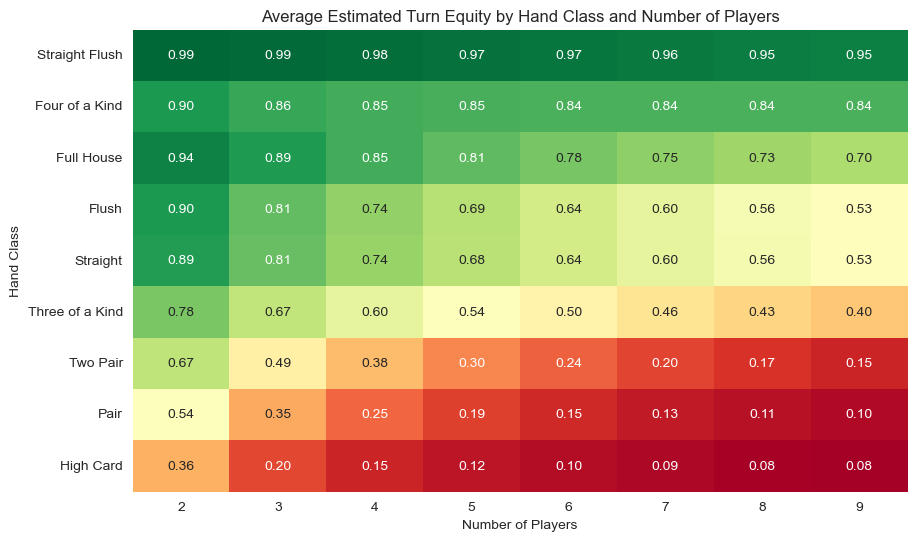

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from deuces import Evaluator

evaluator = Evaluator()

# Pivot for heatmap: win_freq by hand_class and players
pivot = turn_equity.pivot_table(
    index='hand_class', columns='players', values='win_freq', aggfunc='mean'
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(pivot, annot=True, fmt=".2f", cmap='RdYlGn', cbar=False)
plt.title("Average Estimated Turn Equity by Hand Class and Number of Players")
plt.ylabel("Hand Class")
plt.xlabel("Number of Players")

hand_class_labels = [evaluator.class_to_string(cls) for cls in pivot.index]
ax.set_yticklabels(hand_class_labels, rotation=0)
plt.savefig('../figures/turn_equity.png', dpi=300)
plt.show()

The results are a little strange, specifically the equity not being equal to 1.0 for Straight Flushes. This is likely due to the fact that we are estimating equity based on hand features, and there are very few instances of Straight Flushes in the dataset, leading to a less reliable estimate. This also might be caused by the fact that most Straight Flushes are using more of the board than of players' hole cards, causing most Straight Flushes that come out to be somewhat shared by the players. However, we can see that the general trend of stronger hands having higher equity holds true, and the model should be able to pick up on how certain features do not affect hand strength as much on the turn and river compared to the flop.

**River Equity Features**: We estimate river equity by grouping hands based on features that can be engineered from the hole cards and community cards (flop + turn + river). Some of these features are the same, however certain features that measure hand potential are no longer relevant on the river, since there are no more cards to come. These features include:
- Hand Classification: Pair, High Card, etc.
- Pocket Pair: Boolean indicating if the hole cards are a pocket pair.
- Suited: Boolean indicating if the hole cards are suited.
- Overcards: Number of hole cards that are higher than the highest card on the board.
- Board Texture: Number of unique suits on the board.
- Board Connectivity: Number of cards required to complete a straight on the board.

In [5]:
river_hands = hands_long[[
    'hole_', 'flop', 'turn', 'river', 'river_eval_', 'showdown_order_'
]].copy()

# add engineered features for river equity calculation
river_hands['hand_class'] = river_hands['river_eval_'].apply(hand_classification)
river_hands['pocket_pair'] = river_hands['hole_'].apply(is_pocket_pair)
river_hands['suited'] = river_hands['hole_'].apply(is_suited)

river_hands['overcards'] = river_hands[['hole_', 'flop', 'turn', 'river']].apply(
    lambda row: overcards(row['hole_'], row['flop'] + [row['turn'], row['river']]),
    axis=1
)
river_hands['suit_texture'] = river_hands[['flop','turn','river']].apply(
    lambda row: suit_texture(row['flop'] + [row['turn'], row['river']]),
    axis=1
)
river_hands['rank_texture'] = river_hands[['flop','turn','river']].apply(
    lambda row: rank_texture(row['flop'] + [row['turn'], row['river']]),
    axis=1
)
river_hands['board_connectivity'] = river_hands[['flop', 'turn', 'river']].apply(
    lambda row: board_connectivity(row['flop'] + [row['turn'], row['river']]),
    axis=1
)
# drop unnecessary columns
river_hands = river_hands.drop(columns=['hole_', 'flop', 'turn', 'river', 'river_eval_'])

from src.helpers import total_hands, wins

# multiply by number of players to account for different player counts
river_hands = pd.concat([river_hands.assign(players=players) for players in range(2,10)], ignore_index=False)

river_hands['total_hands'] = river_hands['players'].apply(total_hands)

river_hands['wins'] = river_hands[['showdown_order_','players']].apply(
    lambda row: wins(row['showdown_order_'], row['players']),
    axis=1
)

# aggregate to get total wins and total hands for each condition
river_equity = river_hands.groupby(
    ['players', 'hand_class', 'pocket_pair', 'suited', 'overcards', 'suit_texture', 'rank_texture', 'board_connectivity']
).agg(
    total_wins=('wins', 'sum'),
    total_hands=('total_hands', 'sum'),
).reset_index()
# compute win frequency
river_equity['win_freq'] = river_equity['total_wins'] / river_equity['total_hands']

# preview data
river_equity.head()

,players,hand_class,pocket_pair,suited,overcards,suit_texture,rank_texture,board_connectivity,total_wins,total_hands,win_freq
0,2,1,False,False,0,1,5,High,103,104,0.990385
1,2,1,False,False,0,1,5,Low,48,48,1.000000
2,2,1,False,False,0,1,5,Medium,24,24,1.000000
3,2,1,False,False,0,2,4,High,22,24,0.916667
4,2,1,False,False,0,2,4,Low,16,16,1.000000


In [6]:
# save locally
river_equity.to_pickle('../data/river_equity.pkl')
river_equity.to_csv('../data/river_equity.csv', index=False)

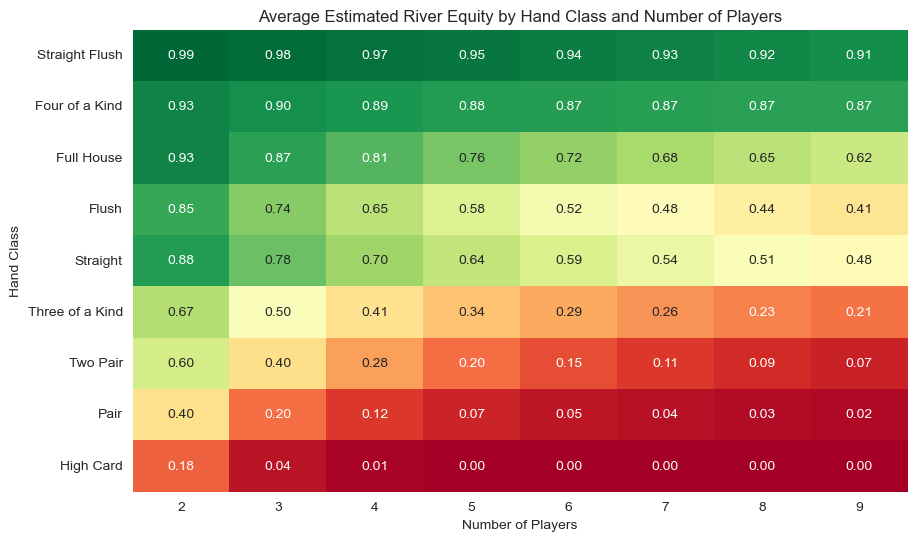

In [7]:

# Pivot for heatmap: win_freq by hand_class and players
pivot = river_equity.pivot_table(
    index='hand_class', columns='players', values='win_freq', aggfunc='mean'
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(pivot, annot=True, fmt=".2f", cmap='RdYlGn', cbar=False)
plt.title("Average Estimated River Equity by Hand Class and Number of Players")
plt.ylabel("Hand Class")
plt.xlabel("Number of Players")

hand_class_labels = [evaluator.class_to_string(cls) for cls in pivot.index]
ax.set_yticklabels(hand_class_labels, rotation=0)
plt.savefig('../figures/river_equity.png', dpi=300)
plt.show()

**Conclusion**: In this notebook, we calculated the turn and river equity for each player's hand based on various engineered features derived from the hole cards and community cards. We grouped hands by these features and estimated the equity for each group, similar to the approach used for pre-flop and flop equity calculations. The results showed that while certain features have less impact on hand strength as the game progresses, the general trend of stronger hands having higher equity remains consistent. This analysis provides valuable insights into hand strength dynamics throughout a poker game.